### Data generation
(Optional; in case you do not have real gene sequence data)

In [1]:
from metal import Metal 
from utils.plot_tree import print_tree, plot_tree
from utils.treetools import save_trees, compute_split_frequencies
from data_generation import TreeSimulator, SequenceSimulator
import random
import os 
import matplotlib.pyplot as plt

In [2]:
num_gene_trees = 100
num_sites_per_gene = 100
mutation_rate = 0.1

In [3]:
dir_name = "data"

if dir_name not in os.listdir("."):  
    os.mkdir(dir_name)

In [4]:
rng = random.Random(0)

tree_sim = TreeSimulator(ntax=10, tree_diameter=1.0, rng=rng)

# Generate species tree
tree_sim.generate_species_tree()
tree_sim.get_species_tree().write(path=f"{dir_name}/species_tree.nex", schema="nexus")

# Generate gene trees
gene_trees = tree_sim.generate_multiple_gene_trees(num_gene_trees)
gene_trees.write(path=f"{dir_name}/gene_trees.nex", schema="nexus")

Species tree generated.
Gene trees generated.


In [5]:
#Generate a fasta file of the concatenated sequences of gene trees

seq_sim = SequenceSimulator(seq_length=num_sites_per_gene, mutation_rate=mutation_rate, seed=42)

fasta_filepath = f"{dir_name}/concatenated_seq_alignment.fasta"
seq_sim.write_concatenated(gene_trees, fasta_filepath)

Generating & concatenating sequences: 100%|█████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.80it/s]


In [6]:
est = Metal(fasta_filepath, seed = 0)
est.estimate_tree()
print_tree(est.metal_tree, show_support=False, show_lengths=False)

└── *
    ├── *
    │   ├── a
    │   └── *
    │       ├── e
    │       └── d
    └── *
        ├── *
        │   ├── c
        │   └── *
        │       ├── h
        │       └── f
        └── *
            ├── g
            └── *
                ├── b
                └── *
                    ├── i
                    └── j


In [7]:
boot_trees = est.bootstrap_hamming(n_bootstraps = 100)
gauss_trees = est.gaussian_sampling(n_bootstraps = 1000, mutation_rate=0.1, sites_per_gene=100)

Bootstrapping: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 200.62it/s]


In [8]:
metal_boot_support = compute_split_frequencies(est.metal_tree, boot_trees)
metal_gauss_support = compute_split_frequencies(est.metal_tree, gauss_trees)

In [9]:
print(" Bootstrap ".center(30,"#"))
print_tree(metal_boot_support,show_lengths=False)
print(" Gaussian ".center(30,"#"))
print_tree(metal_gauss_support,show_lengths=False)

######### Bootstrap ##########
└── *
    ├── [1.000]
    │   ├── a
    │   └── [1.000]
    │       ├── e
    │       └── d
    └── [1.000]
        ├── [1.000]
        │   ├── c
        │   └── [1.000]
        │       ├── h
        │       └── f
        └── [0.900]
            ├── g
            └── [1.000]
                ├── b
                └── [0.990]
                    ├── i
                    └── j
########## Gaussian ##########
└── *
    ├── [0.999]
    │   ├── a
    │   └── [0.854]
    │       ├── e
    │       └── d
    └── [0.999]
        ├── [0.974]
        │   ├── c
        │   └── [0.841]
        │       ├── h
        │       └── f
        └── [0.638]
            ├── g
            └── [0.924]
                ├── b
                └── [0.856]
                    ├── i
                    └── j


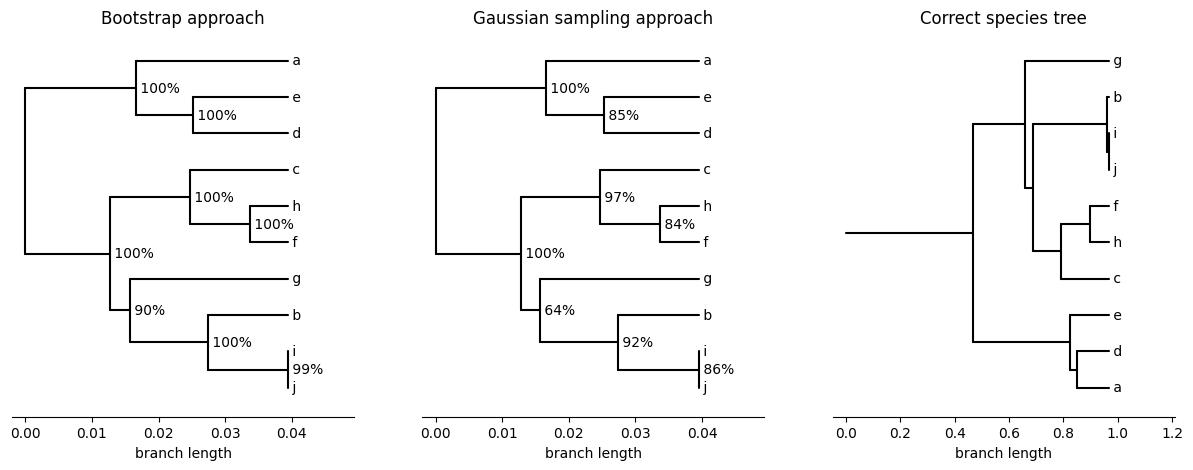

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot_tree(metal_boot_support, ax = ax1)
plot_tree(metal_gauss_support, ax = ax2)
plot_tree(tree_sim.species_tree, ax = ax3)

ax1.set_title("Bootstrap approach")
ax2.set_title("Gaussian sampling approach")
ax3.set_title("Correct species tree")

plt.show()